<a href="https://colab.research.google.com/github/SophieShin/DeepLearning/blob/main/%5BAIM5004%5DAssignment_2(SoheeShin).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



###1. Training Convolutional Neural Networks (CNN). You are going to write codes in python w/ whichever deep learning libraries you prefer to use, e.g. pytorch, tensorflow, keras, jax,mxnet, and so on.


#### (a) Download CIFAR-10 dataset from https://www.cs.toronto.edu/~kriz/cifar.htmland report the statistics of the dataset, e.g. how many training (and testing) images,the size of each image, the number of class and the number of images per each classes.Also show random 5 images from each classes. Report the mean and standard deviation of the training datasets for each color channels (R,G,B). (1 pts)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Use GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# Load the data
transform = transforms.Compose([transforms.ToTensor()])

train_set = torchvision.datasets.CIFAR10('./', train = True, download = True, transform = transform)
test_set = torchvision.datasets.CIFAR10('./', train = False, download = True, transform = transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [ ]:
train_set

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [4]:
# Hyperparameters
# 교수님께서 epochs을 약간 달리 해도 된다고 하셔서 5로 했을 때 학습이 잘 안되어 10으로 하였습니다.

batch_size = 4
learning_rate = 0.001
momentum = 0.9
num_epochs = 10

In [5]:
# Get batches by using dataloader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle = False)

classes = train_set.classes
print(f'classes= {classes}')


classes= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [6]:
# Statistics of the dataset
batch = next(iter(train_loader))
print(f'Number of Train data : {len(train_set)}')
print(f'Number of Test data : {len(test_set)}')
print(f'Image Size[batch, channel, width, height]: {batch[0].shape}')


Number of Train data : 50000
Number of Test data : 10000
Image Size[batch, channel, width, height]: torch.Size([4, 3, 32, 32])


In [ ]:
# the number of images per each classes in training set

dataset_size = len(train_set)
classes = train_set.classes
num_classes = len(train_set.classes)
img_dict = {}
for i in range(num_classes):
    img_dict[classes[i]] = 0

for i in range(dataset_size):
    img, label = train_set[i]
    img_dict[classes[label]] += 1

img_dict

{'airplane': 5000,
 'automobile': 5000,
 'bird': 5000,
 'cat': 5000,
 'deer': 5000,
 'dog': 5000,
 'frog': 5000,
 'horse': 5000,
 'ship': 5000,
 'truck': 5000}

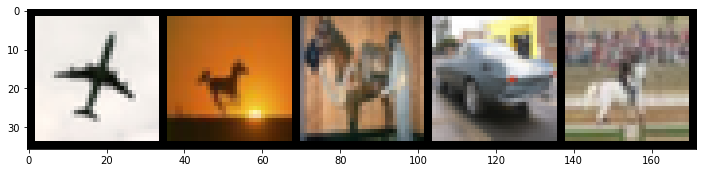

In [ ]:
# view 5 images
train_loader_5 = torch.utils.data.DataLoader(train_set, batch_size=5, shuffle = True)
batch_5 = next(iter(train_loader_5))
images_5, labels_5 = batch_5
plt.figure(figsize = (12,12))
grid = torchvision.utils.make_grid(tensor = images_5, nrow = 5)
plt.imshow(grid.permute(1,2,0))


In [7]:
# the mean and standard deviation of the training datasets for each color channels

R_channel, G_channel, B_channel = [], [], []

for i in range(len(train_set)):
  R_channel.append(train_set[i][0][0].reshape(1,-1).numpy())
  G_channel.append(train_set[i][0][1].reshape(1,-1).numpy())
  B_channel.append(train_set[i][0][2].reshape(1,-1).numpy())
  i += 1

print(f'The mean and std of R Channel : {np.mean(R_channel)}, {np.std(R_channel)} ')
print(f'The mean and std of G Channel : {np.mean(G_channel)}, {np.std(G_channel)} ')
print(f'The mean and std of B Channel : {np.mean(B_channel)}, {np.std(B_channel)} ')

The mean and std of R Channel : 0.4913996756076813, 0.24703232944011688 
The mean and std of G Channel : 0.48215827345848083, 0.24348504841327667 
The mean and std of B Channel : 0.4465312361717224, 0.2615876793861389 


#### (b) Design a CNN architecture and write the training codes w/ the following hyperparameters. Provide a training loss curve (x-axis: the number of training iteration, y-axis: loss value) and a testing accuracy curve (x-axis: the number of training iteration, y-axis: classification accuracy on testing dataset).

[conv1] → input channels: 3, output channels: 6, kernel size: 5, padding: 0, stride:
1
[max pooling] → kernel size: 2, stride: 2
[conv2] → input channels: 6, output channels: 16, kernel size: 5, padding: 0,
stride: 1
[fully connected layer1] → output channels: 120
[fully connected layer2] → output channels: 84
[fully connected layer3] → output channels: 10

In [8]:
# Compute number of nodes before feeding FC
size = (32-4)/2 -4
out_channel = 16
num_nodes = int(size * size * out_channel)
print(f'num_nodes: {num_nodes}')

num_nodes: 1600


In [9]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels=6, kernel_size = 5, stride = 1, padding = 0)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels=16, kernel_size = 5, stride = 1, padding = 0)
    self.fc1 = nn.Linear(num_nodes, 120) # Flatten 3d tensor to 1d tensor(1600)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)

  def forward(self, x):
    out = self.conv1(x)
    out = self.relu(out)
    out = self.pool(out)
    out = self.conv2(out)
    out = self.relu(out)
    out = out.reshape(-1, num_nodes)
    out = self.fc1(out)
    out = self.relu(out)
    out = self.fc2(out)
    out = self.relu(out)
    out = self.fc3(out)
    return out
    # No softmax as it will be includ in Cross Entropy Loss

In [10]:
model = CNN().to(device)

In [11]:
model.eval()

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [12]:
# Loss Function and optimizer

criterion = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum)

In [13]:
# accuracy function

def get_accuracy(model, data):
  correct = 0
  total = 0
  model.eval()
  for images, labels in data:
    images = images.to(device)
    output = model(images)
    pred = output.max(1, keepdim = True)[1].item()
    if pred == labels:
      correct += 1
    total += 1
  return 100.0 * correct / total


In [14]:
# training

n_total_steps = len(train_set)
n_iterations = -(-n_total_steps//batch_size )
losses = []
train_acc = []
test_acc = []

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    output = model(images)
    loss = criterion(output, labels)

    opt.zero_grad()
    loss.backward()
    opt.step()

    if (i+1) % 2500 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, iteration {i+1}/{n_iterations}, loss = {loss.item():.4f}')

  losses.append(float(loss)/batch_size)
  train_acc.append(get_accuracy(model, train_set))
  test_acc.append(get_accuracy(model, test_set))

    

Epoch 1/10, iteration 2500/12500, loss = 1.8431
Epoch 1/10, iteration 5000/12500, loss = 1.6632
Epoch 1/10, iteration 7500/12500, loss = 1.8465
Epoch 1/10, iteration 10000/12500, loss = 1.9679
Epoch 1/10, iteration 12500/12500, loss = 1.0729
Epoch 2/10, iteration 2500/12500, loss = 0.8190
Epoch 2/10, iteration 5000/12500, loss = 1.3858
Epoch 2/10, iteration 7500/12500, loss = 1.5222
Epoch 2/10, iteration 10000/12500, loss = 1.0035
Epoch 2/10, iteration 12500/12500, loss = 1.3485
Epoch 3/10, iteration 2500/12500, loss = 2.2997
Epoch 3/10, iteration 5000/12500, loss = 1.6169
Epoch 3/10, iteration 7500/12500, loss = 1.6534
Epoch 3/10, iteration 10000/12500, loss = 0.6308
Epoch 3/10, iteration 12500/12500, loss = 1.2285
Epoch 4/10, iteration 2500/12500, loss = 1.8033
Epoch 4/10, iteration 5000/12500, loss = 1.2823
Epoch 4/10, iteration 7500/12500, loss = 2.4854
Epoch 4/10, iteration 10000/12500, loss = 0.9499
Epoch 4/10, iteration 12500/12500, loss = 2.9970
Epoch 5/10, iteration 2500/12500

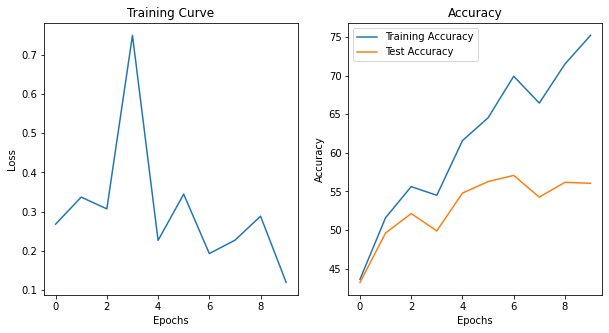

Final Training Accuracy : 75.2
Final Test Accuracy : 56.04
Final Loss : 0.11973629891872406


In [15]:
plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
plt.title('Training Curve')
plt.plot(losses, label = 'Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(train_acc, label = 'Training Accuracy')
plt.plot(test_acc, label = 'Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(f'Final Training Accuracy : {train_acc[-1]}')
print(f'Final Test Accuracy : {test_acc[-1]}')
print(f'Final Loss : {losses[-1]}')

#### (c) Normalize the inputs with mean and standard deviation computed in (1). Compare the training loss and testing accuracy curves by drawing two curves in a same plot. 

In [16]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((np.mean(R_channel),np.mean(G_channel),np.mean(B_channel)), (np.std(R_channel),np.std(G_channel),np.std(B_channel)))])

train_set = torchvision.datasets.CIFAR10('./', train = True, download = True, transform = transform)
test_set = torchvision.datasets.CIFAR10('./', train = False, download = True, transform = transform)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
model.eval()

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [18]:
# Loss Function and optimizer

criterion = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum)

In [19]:
n_total_steps = len(train_set)
n_iterations = -(-n_total_steps//batch_size )
losses = []
train_acc = []
test_acc = []


for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    output = model(images)
    loss = criterion(output, labels)

    opt.zero_grad()
    loss.backward()
    opt.step()

    if (i+1) % 2500 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, iteration {i+1}/{n_iterations}, loss = {loss.item():.4f}')

  losses.append(float(loss)/batch_size)
  train_acc.append(get_accuracy(model, train_set))
  test_acc.append(get_accuracy(model, test_set))

    

Epoch 1/10, iteration 2500/12500, loss = 0.4927
Epoch 1/10, iteration 5000/12500, loss = 1.1523
Epoch 1/10, iteration 7500/12500, loss = 0.0912
Epoch 1/10, iteration 10000/12500, loss = 0.2465
Epoch 1/10, iteration 12500/12500, loss = 0.3823
Epoch 2/10, iteration 2500/12500, loss = 0.8034
Epoch 2/10, iteration 5000/12500, loss = 0.7962
Epoch 2/10, iteration 7500/12500, loss = 1.7935
Epoch 2/10, iteration 10000/12500, loss = 0.4913
Epoch 2/10, iteration 12500/12500, loss = 0.5120
Epoch 3/10, iteration 2500/12500, loss = 1.9799
Epoch 3/10, iteration 5000/12500, loss = 0.5306
Epoch 3/10, iteration 7500/12500, loss = 0.7726
Epoch 3/10, iteration 10000/12500, loss = 0.4413
Epoch 3/10, iteration 12500/12500, loss = 0.6502
Epoch 4/10, iteration 2500/12500, loss = 0.6296
Epoch 4/10, iteration 5000/12500, loss = 0.8529
Epoch 4/10, iteration 7500/12500, loss = 0.1623
Epoch 4/10, iteration 10000/12500, loss = 1.5137
Epoch 4/10, iteration 12500/12500, loss = 0.5216
Epoch 5/10, iteration 2500/12500

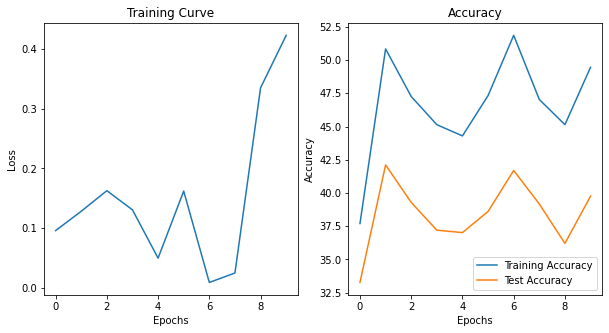

Final Training Accuracy : 49.456
Final Test Accuracy : 39.76
Final Loss : 0.42325282096862793


In [20]:
plt.figure(figsize= (10,5))
plt.subplot(1,2,1)
plt.title('Training Curve')
plt.plot(losses, label = 'Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(train_acc, label = 'Training Accuracy')
plt.plot(test_acc, label = 'Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(f'Final Training Accuracy : {train_acc[-1]}')
print(f'Final Test Accuracy : {test_acc[-1]}')
print(f'Final Loss : {losses[-1]}')

#### (d) Train with a MLP architecture that has the same number of layers (4 layers, each layers have 128 hidden units, ReLU activation function). Compare the training loss and testing accuracy by drawing two curves in a same plot.

In [63]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle = False)

In [64]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(3072, 128)
    self.layer2 = nn.Linear(128, 128)
    self.layer3 = nn.Linear(128, 128)
    self.layer4 = nn.Linear(128, 10)
    self.relu = nn.ReLU()

  def forward(self, img):
    out = img.reshape(1, 3072)
    out = self.layer1(out)
    out = self.relu(out)
    out = self.layer2(out)
    out = self.relu(out)
    out = self.layer3(out)
    out = self.relu(out)
    out = self.layer4(out)
    return out

In [65]:
model = MLP().to(device)

In [66]:
criterion = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum, weight_decay = 0.001)

In [67]:
model.eval()

MLP(
  (layer1): Linear(in_features=3072, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=128, bias=True)
  (layer4): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

In [ ]:
def get_accuracy(model, data):
  correct = 0
  total = 0
  model.eval()
  for images, labels in data:
    images = images.to(device)
    output = model(images)
    pred = output.max(1, keepdim = True)[1].item()
    if pred == labels:
      correct += 1
    total += 1
  return 100.0 * correct / total


In [68]:
n_iterations = len(train_set)
losses = []
train_acc = []
test_acc = []

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    output = model(images)
    loss = criterion(output, labels)

    opt.zero_grad()
    loss.backward()
    opt.step()

    if (i+1) % 2500 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, iteration {i+1}/{n_iterations}, loss = {loss.item():.4f}')

  losses.append(float(loss)/batch_size)
  train_acc.append(get_accuracy(model, train_set))
  test_acc.append(get_accuracy(model, test_set))

Epoch 1/10, iteration 2500/50000, loss = 1.0664
Epoch 1/10, iteration 5000/50000, loss = 1.4463
Epoch 1/10, iteration 7500/50000, loss = 1.6697
Epoch 1/10, iteration 10000/50000, loss = 2.9537
Epoch 1/10, iteration 12500/50000, loss = 1.4414
Epoch 1/10, iteration 15000/50000, loss = 2.2029
Epoch 1/10, iteration 17500/50000, loss = 1.4551
Epoch 1/10, iteration 20000/50000, loss = 1.3173
Epoch 1/10, iteration 22500/50000, loss = 1.3074
Epoch 1/10, iteration 25000/50000, loss = 2.5915
Epoch 1/10, iteration 27500/50000, loss = 1.2339
Epoch 1/10, iteration 30000/50000, loss = 2.5958
Epoch 1/10, iteration 32500/50000, loss = 1.1839
Epoch 1/10, iteration 35000/50000, loss = 2.5900
Epoch 1/10, iteration 37500/50000, loss = 3.1676
Epoch 1/10, iteration 40000/50000, loss = 2.2470
Epoch 1/10, iteration 42500/50000, loss = 1.7774
Epoch 1/10, iteration 45000/50000, loss = 1.9094
Epoch 1/10, iteration 47500/50000, loss = 1.9476
Epoch 1/10, iteration 50000/50000, loss = 1.0480
Epoch 2/10, iteration 2

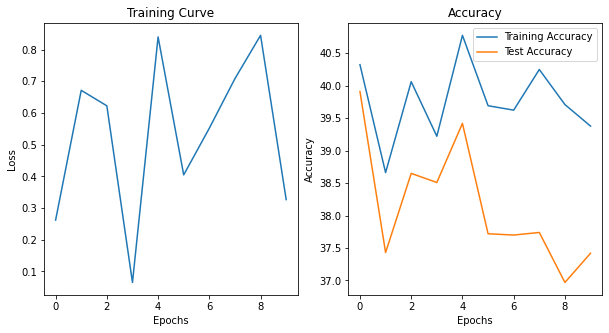

Final Training Accuracy : 39.378
Final Test Accuracy : 37.42
Final Loss : 0.3266226351261139


In [69]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.title('Training Curve')
plt.plot(losses, label = 'Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(train_acc, label = 'Training Accuracy')
plt.plot(test_acc, label = 'Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(f'Final Training Accuracy : {train_acc[-1]}')
print(f'Final Test Accuracy : {test_acc[-1]}')
print(f'Final Loss : {losses[-1]}')

####(e) Train with Adam optimizer and compare the training loss and testing accuracy by drawing two curves in a same plot.

In [21]:
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr = learning_rate)

In [27]:
n_total_steps = len(train_set)
n_iterations = -(-n_total_steps//batch_size )
losses_adam = []
train_acc_adam = []
test_acc_adam = []
num_epochs = 10

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    output = model(images)
    loss = criterion(output, labels)

    opt.zero_grad()
    loss.backward()
    opt.step()

    if (i+1) % 2500 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, iteration {i+1}/{n_iterations}, loss = {loss.item():.4f}')

  losses_adam.append(float(loss)/batch_size)
  train_acc_adam.append(get_accuracy(model, train_set))
  test_acc_adam.append(get_accuracy(model, test_set))

Epoch 1/10, iteration 2500/12500, loss = 0.8103
Epoch 1/10, iteration 5000/12500, loss = 0.0290
Epoch 1/10, iteration 7500/12500, loss = 0.6211
Epoch 1/10, iteration 10000/12500, loss = 0.6761
Epoch 1/10, iteration 12500/12500, loss = 1.0768
Epoch 2/10, iteration 2500/12500, loss = 0.3549
Epoch 2/10, iteration 5000/12500, loss = 1.5045
Epoch 2/10, iteration 7500/12500, loss = 0.0027
Epoch 2/10, iteration 10000/12500, loss = 0.0030
Epoch 2/10, iteration 12500/12500, loss = 2.4530
Epoch 3/10, iteration 2500/12500, loss = 0.0232
Epoch 3/10, iteration 5000/12500, loss = 0.1809
Epoch 3/10, iteration 7500/12500, loss = 1.0030
Epoch 3/10, iteration 10000/12500, loss = 0.7674
Epoch 3/10, iteration 12500/12500, loss = 0.4057
Epoch 4/10, iteration 2500/12500, loss = 0.4366
Epoch 4/10, iteration 5000/12500, loss = 1.5482
Epoch 4/10, iteration 7500/12500, loss = 0.2608
Epoch 4/10, iteration 10000/12500, loss = 1.2125
Epoch 4/10, iteration 12500/12500, loss = 0.2523
Epoch 5/10, iteration 2500/12500

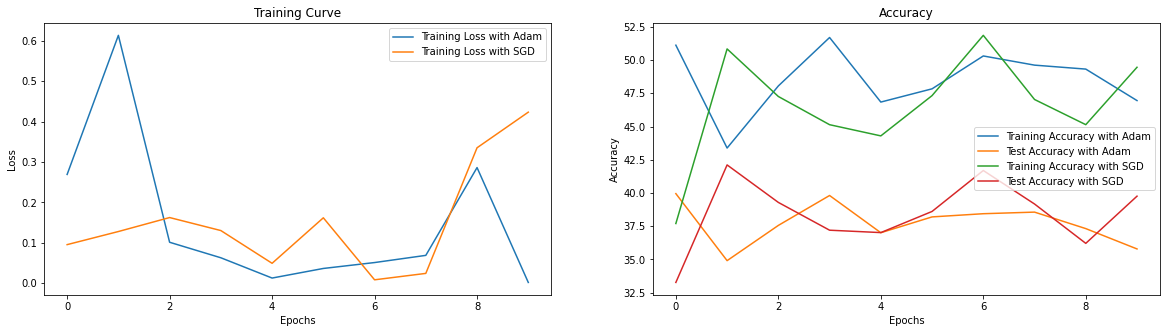

Final Training Accuracy : 46.95
Final Test Accuracy : 35.79
Final Loss : 0.0020364923402667046


In [32]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title('Training Curve')
plt.plot(losses_adam, label = 'Training Loss with Adam')
plt.plot(losses, label = 'Training Loss with SGD')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(train_acc_adam, label = 'Training Accuracy with Adam')
plt.plot(test_acc_adam, label = 'Test Accuracy with Adam')
plt.plot(train_acc, label = 'Training Accuracy with SGD')
plt.plot(test_acc, label = 'Test Accuracy with SGD')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.show()

print(f'Final Training Accuracy : {train_acc_adam[-1]}')
print(f'Final Test Accuracy : {test_acc_adam[-1]}')
print(f'Final Loss : {losses_adam[-1]}')

####(f) Change the hyperparameters and network architectures to achieve better training loss and testing accuracy curves. Provide the final architecture and hyperparameters that you used. 

In [ ]:
# Compute number of nodes before feeding FC
conv1_pool = (32-4)/2
conv2_pool = (conv1_pool-2)/2
conv3_pool = (conv2_pool-2)/2
out_channel = 32
num_nodes = int(conv3_pool* conv3_pool * out_channel)
print(f'conv1: {conv1_pool},conv2: {conv2_pool}, conv3: {conv3_pool}, num_nodes: {num_nodes}')

conv1: 14.0,conv2: 6.0, conv3: 2.0, num_nodes: 128


In [ ]:
class MyModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels=6, kernel_size = 5, stride = 1, padding = 0)
    self.bn1 = nn.BatchNorm2d(num_features = 6)    
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels=16, kernel_size = 3, stride = 1, padding = 0)
    self.bn2 = nn.BatchNorm2d(num_features = 16)    
    self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1, padding = 0)
    self.bn3 = nn.BatchNorm2d(num_features = 32)   
    self.fc1 = nn.Linear(num_nodes, 128) # Flatten 3d tensor to 1d tensor(1600)
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64,10)

  def forward(self, x):
    out = self.conv1(x)
    out = self.bn1(x)
    out = self.relu(out)
    out = self.pool(out)
    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)
    out = self.pool(out)
    out = self.conv3(out)
    out = self.bn3(out)
    out = self.relu(out)
    out = self.pool(out)
    out = out.reshape(-1, num_nodes)
    out = self.fc1(out)
    out = self.relu(out)
    out = self.fc2(out)
    out = self.relu(out)
    out = self.fc3(out)
    return out
    # No softmax as it will be includ in Cross Entropy Loss

In [ ]:
model = MyModel().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum, weight_decay = 0.001)

In [ ]:
num_epochs = 30
n_total_steps = len(train_set)
n_iterations = -(-n_total_steps//batch_size )
losses_adam = []
train_acc_adam = []
test_acc_adam = []

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    output = model(images)
    loss = criterion(output, labels)

    opt.zero_grad()
    loss.backward()
    opt.step()

    if (i+1) % 2500 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, iteration {i+1}/{n_iterations}, loss = {loss.item():.4f}')

  losses_adam.append(float(loss)/batch_size)
  train_acc_adam.append(get_accuracy(model, train_set))
  test_acc_adam.append(get_accuracy(model, test_set))

Epoch 1/30, iteration 2500/12500, loss = 1.6380
Epoch 1/30, iteration 5000/12500, loss = 1.1146
Epoch 1/30, iteration 7500/12500, loss = 2.5790
Epoch 1/30, iteration 10000/12500, loss = 0.7531
Epoch 1/30, iteration 12500/12500, loss = 1.7577
Epoch 2/30, iteration 2500/12500, loss = 1.2021
Epoch 2/30, iteration 5000/12500, loss = 1.5364
Epoch 2/30, iteration 7500/12500, loss = 1.2329
Epoch 2/30, iteration 10000/12500, loss = 1.6756
Epoch 2/30, iteration 12500/12500, loss = 1.4155
Epoch 3/30, iteration 2500/12500, loss = 1.2809
Epoch 3/30, iteration 5000/12500, loss = 2.0641
Epoch 3/30, iteration 7500/12500, loss = 1.1765
Epoch 3/30, iteration 10000/12500, loss = 1.7104
Epoch 3/30, iteration 12500/12500, loss = 0.7250
Epoch 4/30, iteration 2500/12500, loss = 1.1782
Epoch 4/30, iteration 5000/12500, loss = 0.9284
Epoch 4/30, iteration 7500/12500, loss = 1.4074
Epoch 4/30, iteration 10000/12500, loss = 1.4678
Epoch 4/30, iteration 12500/12500, loss = 1.5033
Epoch 5/30, iteration 2500/12500

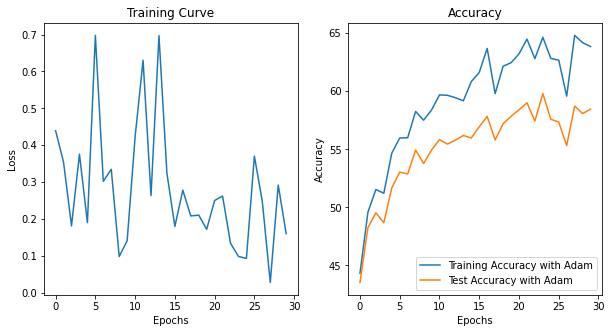

Final Training Accuracy : 63.848
Final Test Accuracy : 58.46
Final Loss : 0.160150408744812


In [ ]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.title('Training Curve')
plt.plot(losses_adam, label = 'Training Loss with Adam')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(train_acc_adam, label = 'Training Accuracy with Adam')
plt.plot(test_acc_adam, label = 'Test Accuracy with Adam')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(f'Final Training Accuracy : {train_acc_adam[-1]}')
print(f'Final Test Accuracy : {test_acc_adam[-1]}')
print(f'Final Loss : {losses_adam[-1]}')

In [ ]:
# Hyper parameters
model.eval()

MyModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
print(f'num_epochs: {num_epochs}')

num_epochs: 30
